In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import EoN

from contact_tracing import *
from constraint import *
from solve import *

In [2]:
#returns the nodes in S, I, R after timesteps 
def initial(G: nx.graph, timesteps=5, p=0.1):

    full_data = EoN.basic_discrete_SIR(G=G, p=p, rho=.0001, tmin=0, tmax=timesteps, return_full_data=True) 
    
    S = [k for (k,v) in full_data.get_statuses(time=timesteps).items() if v == 'S']
    I = [k for (k,v) in full_data.get_statuses(time=timesteps).items() if v == 'I']
    R = [k for (k,v) in full_data.get_statuses(time=timesteps).items() if v == 'R']
    
    print(full_data.I())
    
    return (S, I, R)

In [3]:
def MDP_step(S, I_t, R, Q1, Q2, p):
    
    full_data = EoN.basic_discrete_SIR(G=G, p=p, initial_infecteds=I_t, initial_recovereds=R+Q1+Q2, tmin=0, tmax=1, return_full_data=True)
    
    S = [k for (k,v) in full_data.get_statuses(time=1).items() if v == 'S']
    I = [k for (k,v) in full_data.get_statuses(time=1).items() if v == 'I']
    R = [k for (k,v) in full_data.get_statuses(time=1).items() if v == 'R']
    
    return (S, I, R)

In [4]:
def MDP(G: nx.graph, budget, S, I_t, R, p=0.5, iterations=10, method="dependent", visualization=False):

    Q_infected = []
    Q_susceptible = []
    
    x=[]
    y1=[]
    y2=[]
    y3=[]
    
    if visualization:
        x.append(0)
        y1.append(len(R))
        y2.append(len(I_t))
        y3.append(len(S))
    
    for t in range(iterations):

        print(str(len(I_t)) + " " + str(len(S)) + " " + str(len(R)))

        (val, recommendation) = to_quarantine(G, I_t, R, budget, method=method, p=p)

        (S, I_t, R) = MDP_step(S, I_t, R, Q_infected, Q_susceptible, p=p)
        #after this, R will contain Q_infected and Q_susceptible

        #people from previous timestep get unquarantined (some of these people remain in R because they were infected before quarantine)
        #for node in Q_infected:
        #    R.append(node)

        for node in Q_susceptible:
            R.remove(node)
            S.append(node)

        #reset quarantined lists
        Q_infected = []
        Q_susceptible = []
        
        if visualization:
            x.append(t+1)
            y1.append(len(R))
            y2.append(len(I_t))
            y3.append(len(S))
    
        
        #people are quarantined (removed from graph temporarily after the timestep)
        for (k,v) in recommendation.items():
            if v == 1:
                if k in S:
                    S.remove(k)
                    Q_susceptible.append(k)
                elif k in I_t:
                    I_t.remove(k)
                    Q_infected.append(k)
        
    if visualization:
        colors = ["red", "limegreen", "deepskyblue"]
        labels = ["Infected", "Recovered", "Susceptible"]

        fig, ax = plt.subplots()
        ax.stackplot(x, y2, y1, y3, labels=labels, colors=colors)
        ax.legend(loc='upper left')
        ax.set_title("Epidemic Simulation; Quarantine Method: " + method)
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Number of People")
        plt.show()

In [5]:
G = load_graph('montgomery') #fetching the montgamery graph
n = len(G.nodes)
I0 = [i for i in range(n) if random.random() > 0.99]

In [6]:
(S, I, R) = initial(G)

[  8  24  71 159 332 701]


701 74162 594
1526 72636 1295
3040 69596 2821
5597 63999 5861
8372 55627 11458
9211 46416 19830
6878 39538 29041
3815 35723 35919
1805 33918 39734
742 33176 41539
316 32860 42281
136 32724 42597
57 32667 42733
27 32640 42790
9 32631 42817


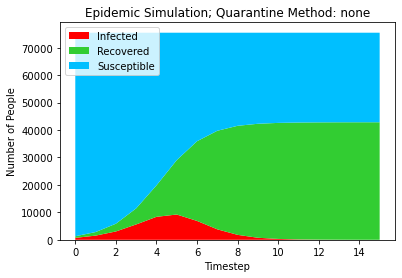

In [7]:
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="none")

701 74162 594
1446 72316 1295
2767 69484 2808
5016 64404 5638
7791 56521 10746
8675 47757 18627
6960 40689 27409
4114 36477 34467
2005 34397 38659
804 33509 40745
305 33156 41598
93 33022 41947
0 33011 42096
0 33321 42136
0 33321 42136


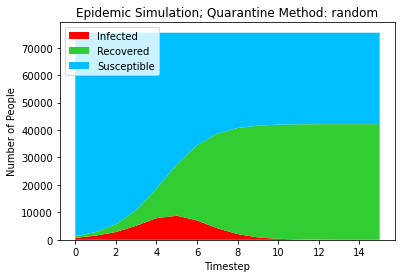

In [8]:
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="random")

701 74162 594
1487 72275 1295
2741 69499 2836
4713 64751 5598
6891 57825 10350
8196 49597 17280
7086 42467 25533
4587 37834 32655
2414 35378 37277
1102 34238 39731
416 33780 40874
101 33641 41322
0 33752 41456
0 33974 41483
0 33974 41483


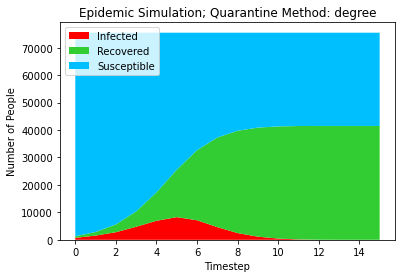

In [9]:
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="degree")

701 74162 594
1366 72396 1295
2661 69615 2814
4587 64883 5616
6937 57780 10369
8000 49584 17508
6728 42633 25729
4354 38038 32700
2178 35638 37277
913 34548 39635
356 34063 40652
116 33884 41065
10 33832 41225
1 34155 41272
0 34179 41273


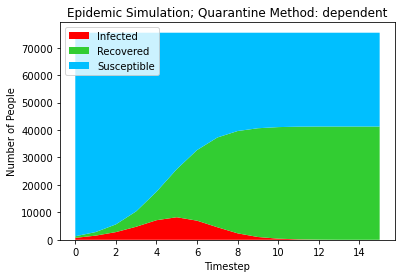

In [10]:
MDP(G, 400, S, I, R, p=0.1, iterations=15, visualization=True, method="dependent")

In [ ]:
"""Stop here"""

In [8]:
COSTS = np.ones(n)

In [28]:
V_1,V_2 = find_excluded_contours(G,I,R)

In [41]:
degrees = []

for u in V_1:
    count = 0
    for v in G.neighbors(u):
        if v in V_2:
            count+=1

    degrees.append((count,u))

degrees.sort()
degrees.reverse()

sol = {}

for i in range(len(V_1)):
    if i < 100:
        sol[degrees[i][1]] = 1
    else:
        sol[degrees[i][1]] = 0

In [43]:
a = 0
for (k,v) in sol.items():
    a+=v
a

100

In [37]:
arr[:5]

[(65, 3751), (62, 27236), (61, 35651), (61, 34538), (60, 18733)]

In [13]:
P,Q = PQ(G,I,p=0.1, runs = 20)

In [20]:
prob = ProbMinExposed.from_dataframe(G,I,V_1,V_2,P,Q,800,COSTS)
#prob.solve_lp()
#prob.objectiveVal

In [21]:
sample = random.sample(range(0, len(V_1)), 800)
#just to not break stuff
prob.solve_lp()

for u in range(0,len(V_1)):
    #print(u)
    if u in sample:
        prob.setVariable(u, 0)
    else:
        prob.setVariable(u, 1)
#print(prob.partials)
print(len(V_1))
print(len(prob.partials))
print(prob.costs)
print(len(prob.costs))
#print(prob.filled())

prob.solve_lp()

3677
3677
[1. 1. 1. ... 1. 1. 1.]
75457


ValueError: Infeasible solution

In [22]:
print(prob.costs.sum())

75457.0


In [24]:
a = 0
for (k,v) in prob.partials.items():
    a += v
print(a)

2877


In [7]:
a = prob.getVariables()
#print(a.sum())
(val, c) = basic_non_integer_round(prob)
#print(c.sum())
#print(val1)
print(val)
#prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
#(val2, b) = iterated_round(prob,100)
#prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
#(val3, d) = optimized_iterated_round(prob, 100)
#print(val2)
#print(val3)
#for i in range(len(a)):
#    if (a[i] != 0) & (a[i] != 1):
#        print(str(a[i]) + " " + str(c[i]))
    
#print(len(a))
#a.sum()

15018.000000000515


In [49]:
for (k,v) in c.items(): 
    print(k)
    print(v)
    break

32768
0.0


In [20]:
print(len(V_1))
len(b)

11298


11298

In [13]:
a1=0
a2=0
a3=0
m1=10000000000
m2=10000000000
m3=10000000000

k=20

for i in range(k):
    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    optimized_iterated_round(prob, 500)
    prob.solve_lp()
    a1 += prob.objectiveVal
    
    if prob.objectiveVal < m1:
        m1 = prob.objectiveVal
    
    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    iterated_round(prob, 500)
    prob.solve_lp()
    a2 += prob.objectiveVal
    
    if prob.objectiveVal < m2:
        m2 = prob.objectiveVal

    prob = ProbMinExposed.from_dataframe(G,I0,V_1,V_2,P,Q,800,COSTS)
    basic_non_integer_round(prob)
    prob.solve_lp()
    a3 += prob.objectiveVal
        
    if prob.objectiveVal < m3:
        m3 = prob.objectiveVal
    
    print(i)
    
a1 /= k
a2 /= k
a3 /= k

print("Average: " + str(a1) + " " + str(a2) + " " + str(a3))
print("Best: " + str(m1) + " " + str(m2) + " " + str(m3))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Average: 13995.412500000286 13970.625000000266 14023.225000000264
Best: 13966.450000000283 13950.600000000224 13992.000000000284


In [8]:
#p1 = defaultdict(lambda: .7)
#q = defaultdict(lambda: defaultdict(lambda : .7))
#prob = ProbMinExposed(G,I0,V_1,V_2,p1,q,10,COSTS)

In [ ]:
#test simplify

a = 1
b = 0

total_a = 0
total_b = 0

n=1000000

for i in range(n):
    (x,y,new_a,new_b) = simplify(a,b)
    
    if x==-1:
        total_a += new_a
        total_b += y
    elif y==-1:
        total_a += x
        total_b += new_b
    else:
        total_a += x
        total_b += y

print(str(total_a/n) + " " + str(a))
print(str(total_b/n) + " " + str(b))

In [ ]:
#test D
p = [.5,.5,.25,.6,.15]

n=10000
total = np.zeros(5)

for i in range(n):
    a = D(p)
    if np.sum(a) != np.sum(p):
        print("oof")
    #print(p)
    total += a
    
total/=n
print(total)

In [ ]:
#test D_prime
p = [.5,.4,.25,.75,.7]

n=5000
total = np.zeros(5)

for i in range(n):
    a = D(p)
    if (np.sum(a) != math.floor(np.sum(p))) & (np.sum(a) != math.ceil(np.sum(p))):
        print("oof")
    #print(p)
    total += a
    
total/=n
print(total)